# RandmForest Regressor

In [1]:
#!/usr/bin/env python3

# This script pulls in salary data, builds and tests several predictive models,
# and then makes salary predictions on test data using the best model


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



def load_file(file):
    '''loads csv to pd dataframe'''
    return pd.read_csv(file)

def consolidate_data(df1, df2, key=None, left_index=False, right_index=False):
    '''perform inner join to return only records that are present in both dataframes'''
    return pd.merge(left=df1, right=df2, how='inner', on=key, left_index=left_index, right_index=right_index)

def clean_data(raw_df):
    '''remove rows that contain salary <= 0 or duplicate job IDs'''
    clean_df = raw_df.drop_duplicates(subset='jobId')
    clean_df = clean_df[clean_df.salary>0]
    return clean_df

def one_hot_encode_feature_df(df, cat_vars=None, num_vars=None):
    '''performs one-hot encoding on all categorical variables and combines result with continous variables'''
    cat_df = pd.get_dummies(df[cat_vars])
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis=1)#,ignore_index=False)

def get_target_df(df, target):
    '''returns target dataframe'''
    return df[target]

def train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    neg_mse = cross_val_score(model, feature_df, target_df, cv=2, n_jobs=num_procs, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)

def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

def save_results(model, mean_mse, predictions, feature_importances):
    '''saves model, model summary, feature importances, and predictions'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importances.csv') 
    np.savetxt('predictions.csv', predictions, delimiter=',')


if __name__ == '__main__':
    #define inputs
    train_feature_file = 'data/train_features.csv'
    train_target_file = 'data/train_salaries.csv'
    test_feature_file = 'data/test_features.csv'

    #define variables
    categorical_vars = ['companyId', 'jobType', 'degree', 'major', 'industry']
    numeric_vars = ['yearsExperience', 'milesFromMetropolis']
    target_var = 'salary'

    #load data
    print("Loading data")
    feature_df = load_file(train_feature_file)
    target_df = load_file(train_target_file)
    test_df = load_file(test_feature_file)

    #consolidate training data
    raw_train_df = consolidate_data(feature_df, target_df, key='jobId')

    #clean, shuffle, and reindex training data -- shuffling may improve cross-validation accuracy
    clean_train_df = shuffle(clean_data(raw_train_df)).reset_index()

    #encode categorical data and get final feature dfs
    print("Encoding data")
    feature_df = one_hot_encode_feature_df(clean_train_df, cat_vars=categorical_vars, num_vars=numeric_vars)
    test_df = one_hot_encode_feature_df(test_df, cat_vars=categorical_vars, num_vars=numeric_vars)

    #get target df
    target_df = get_target_df(clean_train_df, target_var)

    #initialize model list and dicts
    models = []
    mean_mse = {}
    cv_std = {}
    res = {}

    #define number of processes to run in parallel
    num_procs = 2

    #shared model paramaters
    verbose_lvl = 5

    #create models -- hyperparameter tuning already done by hand for each model
    lr = LinearRegression()
    lr_std_pca = make_pipeline(StandardScaler(), PCA(), LinearRegression())
    rf = RandomForestRegressor(n_estimators=60, n_jobs=num_procs, max_depth=25, min_samples_split=60, \
                               max_features=30, verbose=verbose_lvl)
    gbm = GradientBoostingRegressor(n_estimators=40, max_depth=5, loss='ls', verbose=verbose_lvl)

    models.extend([lr, lr_std_pca, rf, gbm])

    #parallel cross-validate models, using MSE as evaluation metric, and print summaries
    print("Beginning cross validation")
    for model in models:
        train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std)
        print_summary(model, mean_mse, cv_std)

    #choose model with lowest mse
    model = min(mean_mse, key=mean_mse.get)
    print('\nPredictions calculated using model with lowest MSE:')
    print(model)

    #train model on entire dataset
    model.fit(feature_df, target_df)

    #create predictions based on test data
    predictions = model.predict(test_df)

    #store feature importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        #linear models don't have feature_importances_
        importances = [0]*len(feature_df.columns)

    feature_importances = pd.DataFrame({'feature':feature_df.columns, 'importance':importances})
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    
    #set index to 'feature'
    feature_importances.set_index('feature', inplace=True, drop=True)
    

Loading data
Encoding data
Beginning cross validation

Model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Average MSE:
 384.4793433731719
Standard deviation during CV:
 0.7810680841486146

Model:
 Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])
Average MSE:
 384.4923601259468
Standard deviation during CV:
 0.7779505769686352
building tree 2 of 60
building tree 1 of 60
building tree 1 of 60
building tree 2 of 60
building tree 3 of 60
building tree 4 of 60
building tree 3 of 60
building tree 4 of 60
building tree 5 of 60
building tree 5 of 60
building tree 6 of 60
building tree 6 of 60
building tree 7 of 60
building tree 7 of 60
building tree 8 of 60
building tree 

[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   32.3s


building tree 16 of 60


[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   32.3s


building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 27 of 60
building tree 28 of 60
building tree 28 of 60
building tree 29 of 60
building tree 29 of 60
building tree 30 of 60
building tree 30 of 60
building tree 31 of 60
building tree 31 of 60
building tree 32 of 60
building tree 32 of 60
building tree 33 of 60
building tree 33 of 60
building tree 34 of 60
building tree 34 of 60
building tree 35 of 60
building tree 35 of 60
building tree 36 of 60
building tree 36 of 60
building tree 37 of 60
building tree 37 of 60
building tr

[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  2.2min finished
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  2.2min finished
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    6.5s finished
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    6.6s finished



Model:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=30, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=60, min_weight_fraction_leaf=0.0,
           n_estimators=60, n_jobs=2, oob_score=False, random_state=None,
           verbose=5, warm_start=False)
Average MSE:
 368.5484722612445
Standard deviation during CV:
 0.5568243865558884
      Iter       Train Loss   Remaining Time 
      Iter       Train Loss   Remaining Time 
         1        1352.1477            3.43m
         1        1350.4125            3.36m
         2        1230.9103            3.41m
         2        1228.7266            3.37m
         3        1130.7964            3.30m
         3        1128.6776            3.27m
         4        1046.8173            3.13m
         4        1044.7541            3.11m
         5         975.5484            2.94m
         5         973.4080       

[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   38.6s


building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60
building tree 57 of 60
building tree 58 of 60
building tr

[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  2.7min finished
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    8.7s finished


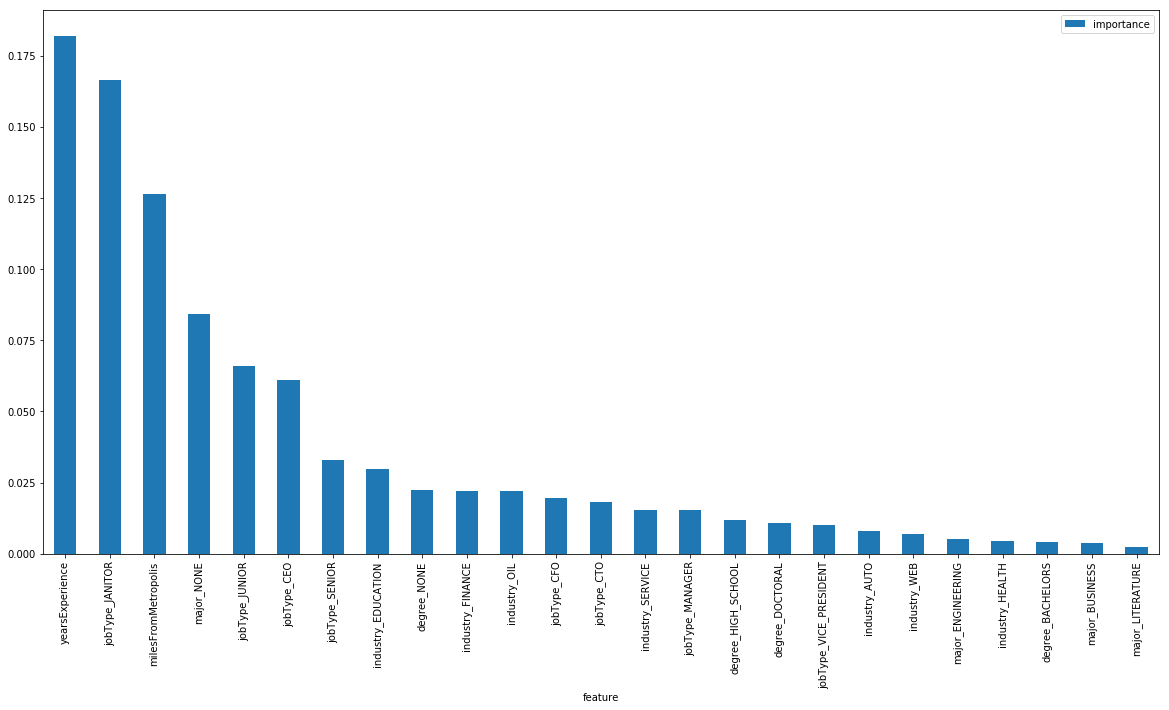

In [2]:
#create plot
feature_importances[0:25].plot.bar(figsize=(20,10))
plt.show()

#save results
save_results(model, mean_mse[model], predictions, feature_importances)
